# Set up

In [0]:
# make sure Python version is 3.5 and later
import sys
sys.version_info >= (3, 5)

# make sure sklearn version is 0.20 and later
import sklearn
sklearn.__version__ >= '0.20'

# common imports
import os
import numpy as np

# figure settings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# save figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "runner_keeper_fitness"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, file_extension='png', tight_layout=True, dpi=300):
  path=os.path.join(IMAGES_PATH, fig_id + '.' + file_extension)
  print('Saving pictures: ', fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=file_extension, dpi=dpi)

# Get data

In [0]:
import os
import urllib

URL_PATH = 'https://raw.githubusercontent.com/AilingLiu/Analyze-Your-Runkeeper-Fitness-Data/master/datasets/cardioActivities.csv'
FITNESS_PATH = os.path.join("datasets", "fitness")

def fetch_fitness_data(download_path=URL_PATH, fitness_path=FITNESS_PATH):
  if not os.path.isdir(fitness_path):
    os.makedirs(fitness_path)
  filepath = os.path.join(fitness_path, "fitness.csv")
  urllib.request.urlretrieve(download_path, filepath)

In [0]:
fetch_fitness_data()

In [0]:
import pandas as pd

def load_dataset(fitness_path=FITNESS_PATH):
  csv_path=os.path.join(fitness_path, 'fitness.csv')
  return pd.read_csv(csv_path)

In [5]:
fitness = load_dataset()
fitness.head()

,Date,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
0,2018-11-11 14:05:12,c9627fed-14ac-47a2-bed3-2a2630c63c15,Running,NaN,10.44,58:40,5:37,10.68,774.0,130,159.0,NaN,NaN,2018-11-11-140512.gpx
1,2018-11-09 15:02:35,be65818d-a801-4847-a43b-2acdf4dc70e7,Running,NaN,12.84,1:14:12,5:47,10.39,954.0,168,159.0,NaN,NaN,2018-11-09-150235.gpx
2,2018-11-04 16:05:00,c09b2f92-f855-497c-b624-c196b3ef036c,Running,NaN,13.01,1:15:16,5:47,10.37,967.0,171,155.0,NaN,NaN,2018-11-04-160500.gpx
3,2018-11-01 14:03:58,bc9b612d-3499-43ff-b82a-9b17b71b8a36,Running,NaN,12.98,1:14:25,5:44,10.47,960.0,169,158.0,NaN,NaN,2018-11-01-140358.gpx
4,2018-10-27 17:01:36,972567b2-1b0e-437c-9e82-fef8078d6438,Running,NaN,13.02,1:12:50,5:36,10.73,967.0,170,154.0,NaN,NaN,2018-10-27-170136.gpx


# A quick look of data structure

The are 14 attributes in this dataset:

* Date: in date long format
* Activity ID: seems like a unique identifier
* Type: categorical values, check the distinct types
* Route Name: lots of null in head, need to check total number of nonnull values
* Distance(km)
* Duration: in h:m:s date string format
* Average Pace
* Average Speed (km/h)
* Calories Burned
* Climb (m)
* Average Heart Rate (bpm)
* Friend's Tagged: lots of null in the head rows, need to check total number of nonnull values
* Notes: lots of null in the head rows (need to check total number of nonnull values)
* GPX File: a combination of DateTime.gpx string format

In [11]:
fitness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 14 columns):
Date                        508 non-null object
Activity Id                 508 non-null object
Type                        508 non-null object
Route Name                  1 non-null object
Distance (km)               508 non-null float64
Duration                    508 non-null object
Average Pace                508 non-null object
Average Speed (km/h)        508 non-null float64
Calories Burned             508 non-null float64
Climb (m)                   508 non-null int64
Average Heart Rate (bpm)    294 non-null float64
Friend's Tagged             0 non-null float64
Notes                       231 non-null object
GPX File                    504 non-null object
dtypes: float64(5), int64(1), object(8)
memory usage: 55.7+ KB


# Notes
## Datafrae shape
Total 508 rows, quite a small dataset.
Total 14 attributes.


## Data Type

- Duration is in object type. Consider to transform it into numerical values.
- Average pace is in object type. Check the number of distinct values. Consider to transform it into numerical values/or maybe distinct categories.
- Check the categorical attribute Type, how many distinct types?

## Non-Null values

- Routname has only one non-null object. Consider to drop this attribute.
- Average Heart Rate (bmp) has 294 nonnull values. Can we predict this using other attributes? Check collinearity
- Friend's Tagged has no non-null values. Drop this columns (if I have a data provider, I would ask the reasons cause this: mistakes?)
- Notes has only 231 non-null values. Can we interprete it from other attributes?



In [14]:
fitness.nunique() #number of unique values for all attributes

Date                        508
Activity Id                 508
Type                          4
Route Name                    1
Distance (km)               363
Duration                    458
Average Pace                146
Average Speed (km/h)        271
Calories Burned             406
Climb (m)                   218
Average Heart Rate (bpm)     49
Friend's Tagged               0
Notes                         7
GPX File                    504
dtype: int64

In [16]:
fitness.Type.value_counts()

Running    459
Cycling     29
Walking     18
Other        2
Name: Type, dtype: int64

In [15]:
fitness.describe()

,Distance (km),Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged
count,508.000000,508.000000,5.080000e+02,508.00000,294.000000,0.0
mean,11.757835,11.341654,1.878197e+04,128.00000,143.530612,NaN
std,6.209219,2.510516,2.186930e+05,108.52604,10.583848,NaN
min,0.760000,1.040000,4.000000e+01,0.00000,77.000000,NaN
25%,7.015000,10.470000,4.917500e+02,53.00000,140.000000,NaN
50%,11.460000,11.030000,7.280884e+02,92.00000,144.000000,NaN
75%,13.642500,11.642500,9.212500e+02,172.25000,149.000000,NaN
max,49.180000,24.330000,4.072685e+06,982.00000,172.000000,NaN


Saving pictures:  attribute_histogram_plot


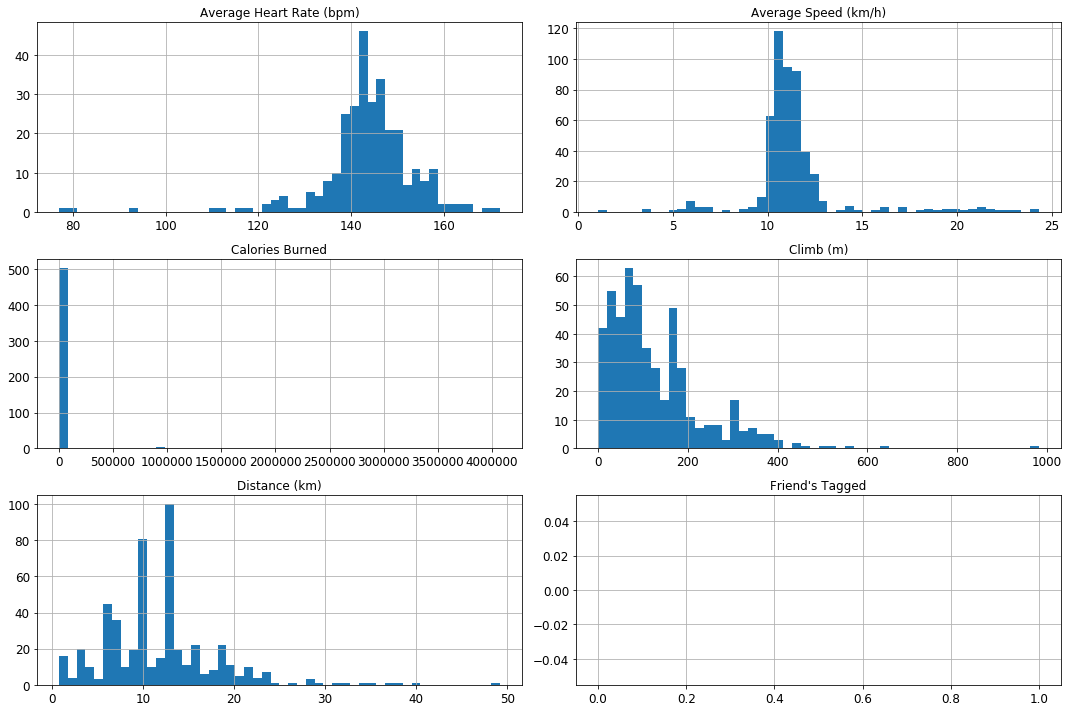

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fitness.hist(bins=50, figsize=(15, 10))
save_fig('attribute_histogram_plot')
plt.show()

- Average heart rate and speed and approximately bell shape, with some outliers.
- Climb(m) attribute is tail-heavy to the right.
- Distance attribute have long tail to the right, and clustered in 10 and 13.

# Split test set

In [0]:
import numpy as np
np.random.seed(42) #set seed so everytime rerun the notebook gets the same dataset

In [0]:
# simple test train split
def test_train_split(data, test_ratio):
  shuffled_ids = np.random.permutation(len(data))
  test_size=int(test_ratio*len(data))
  test_indices=shuffled_ids[:test_size]
  train_indices=shuffled_ids[test_size:]

  return data.iloc[train_indices], data.iloc[test_indices]

In [16]:
train_set, test_set = test_train_split(fitness, 0.2)
len(train_set)

407

In [17]:
len(test_set)

101

If the dataset will be updated in the long run, we can use hash of identifier to make sure the new updated data test set will not include those that were in train set before.

In [0]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
  return hash(identifier).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column):
  ids=data[id_column]
  in_test_set=ids.apply(lambda id_: test_set_check(id_.encode('utf-8'), test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [52]:
train_set, test_set = split_train_test_by_id(fitness, 0.2, 'Activity Id')
len(train_set)

413

In [53]:
len(test_set)

95

In [54]:
test_set.head()

,Date,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
5,2018-10-19 17:52:32,fe2cb3fc-6330-40fa-8a92-0f86f4e72282,Running,NaN,10.29,59:18,5:46,10.41,764.0,133,155.0,NaN,NaN,2018-10-19-175232.gpx
19,2018-08-01 18:20:26,03006a09-870b-4f15-bb6c-9b979793e75a,Running,NaN,18.20,1:43:05,5:40,10.59,1355.0,259,145.0,NaN,NaN,2018-08-01-182026.gpx
24,2018-07-18 08:08:39,1906f2c4-e77e-4364-98f2-f4eb1d8c9960,Running,NaN,11.04,55:41,5:03,11.90,801.0,87,NaN,NaN,NaN,2018-07-18-080839.gpx
31,2018-06-18 18:17:49,874c8870-8621-4356-81fd-e309d38f714a,Running,NaN,11.63,1:02:52,5:24,11.10,811.0,145,141.0,NaN,TomTom MySports Watch,2018-06-18-181749.gpx
33,2018-06-13 18:50:49,2f10b609-c2ef-4d8d-90ad-bd49cec2c41b,Running,NaN,12.75,1:07:30,5:18,11.34,890.0,173,147.0,NaN,TomTom MySports Watch,2018-06-13-185049.gpx


In [62]:
test_set['Activity Id'].any() in train_set['Activity Id']

False

Another simplistic way is to use sklearn package

In [0]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(fitness, test_size=0.2, random_state=42)

In [64]:
len(train_set)

406

# stratified split

We can split the test set to make sure it contains the same ratio of Distance attribute.

In [0]:
# first bin the data according to distance into buckets.

fitness['distance_cat'] = pd.cut(fitness['Distance (km)'], 
                                 bins=5,
                                 labels=False)

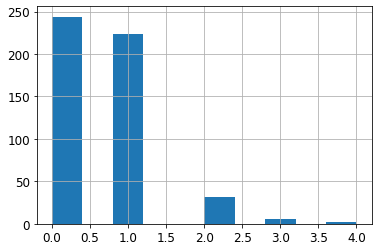

In [74]:
fitness['distance_cat'].hist()

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(fitness, fitness['distance_cat']):
  strat_train_set=fitness.loc[train_index]
  strat_test_set=fitness.loc[test_index]

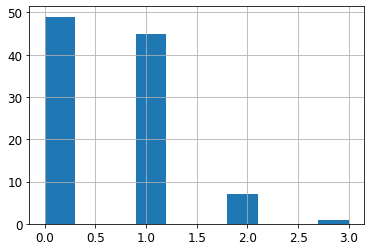

In [76]:
strat_test_set['distance_cat'].hist()